**MDS7203 Modelos Generativos Profundos, Primavera 2023**

# Laboratorio 5: Modelos de difusión

**Profesor**: Felipe Tobar

**Auxiliares**: Cristóbal Alcázar, Camilo Carvajal Reyes.
**Ayudante**: Joaquín Barceló.  
**Nombre**: Arturo Lazcano.

**Fecha de entrega**: 30 de Noviembre 2023

**Instrucciones**: El presente laboratorio tiene como objetivo la implementación de algunos elementos que conforman la familia de modelos basados en score. El formato de entrega consistirá en un archivo de extensión .ipynb (que puede ser una copia del presente notebook) donde contenga el código con sus respuestas tanto de código como teóricas (que deberán presentarse en celdas de Markdown). Considere que:
- El código debe estar ordenado de modo que quien lo lea entienda su contenido.
- Las respuestas deben ser precisas y concisas.
- El notebook debe ser ejecutable sin errores. Se recomienda verificar esto último reiniciando la kernel antes de entregar.

Algunos links útiles:

* <a href="https://arxiv.org/abs/2006.11239" target="_blank">Denoising Diffusion Probabilistic Models (Ho et al., 2020)</a> sobre framework para entrenar modelos de difusión.
* <a href="https://arxiv.org/abs/2010.02502" target="_blank">Denoising Diffusion Implicit Models (Song et al., 2020)</a> sobre acelerar el proceso de muestreo.
*  <a href="https://arxiv.org/abs/2105.05233" target="_blank">Diffusion Models Beat GANs on Image Synthesis (Dhariwal, Nichol 2021)</a> y <a href="https://arxiv.org/abs/2105.05233" target="_blank">GLIDE: Towards Photorealistic Image Generation and Editing with Text-Guided Diffusion Models (Nichol et al, 2022)</a> sobre _Classifier Guidance_.

In [1]:
# instalar librería diffusers
%pip install -q diffusers accelerate open-clip-torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 52.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import time

import torch
import torchvision

from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel, DDIMScheduler, DDPMPipeline

from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


## 1. Entrenando un modelo de difusión: Simplificado y DDPM

> a) (1.5 pts) Usando que $x_t = \sqrt{\bar \alpha_t}x_0 + \sqrt{1-\bar\alpha_t} \epsilon$ con $\epsilon \sim \mathcal{N}(0,I)$, demuestre que
\begin{alignat}{2}
L & = \arg\min_{\theta} \frac{1}{2\sigma_q^2} \left[ \| \mu_\theta(x_t,t) - \mu_q(x_0,x_t) \|^2_2 \right] \\
& = \arg\min_\theta \frac{\beta_t^2}{2\sigma_q^2 \alpha_t(1-\bar\alpha_t)} \left[ \| \epsilon - \epsilon_\theta(x_t,t) \|^2_2 \right]
\end{alignat}
>
> Con esto se justifica la parametrización de Ho et al. 2020 [1].
>
> [1] Ho, J., Jain, A., & Abbeel, P. (2020). Denoising diffusion probabilistic models. Advances in neural information processing systems, 33, 6840-6851.

**Respuesta:** Sea $L = \arg\min_{\theta} \frac{1}{2\sigma_q^2} \left[ \| \mu_\theta(x_t,t) - \mu_q(x_0,x_t) \|^2_2 \right]$ y $x_t = \sqrt{\bar \alpha_t}x_0 + \sqrt{1-\bar\alpha_t} \epsilon$ con $\epsilon \sim \mathcal{N}(0,I)$ tenemos que
\begin{align}
  L &= \mathbb{E}_{x_0,\epsilon} \bigg[ \frac{1}{2\sigma_t^2} \bigg\lvert\bigg\lvert \mu_{q}\bigg(x_t, \frac{1}{\sqrt{\bar{\alpha_t}}}(x_t - \sqrt{1-\bar{\alpha_t}}\epsilon)\bigg) -  \mu_{\theta} (x_t,t) \bigg\rvert\bigg\rvert^2\bigg] \\
  &= \mathbb{E}_{x_0,\epsilon} \bigg[ \frac{1}{2\sigma_t^2} \bigg\lvert\bigg\lvert \frac{1}{\sqrt{\bar{\alpha_t}}}\bigg(x_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha_t}}}\epsilon\bigg) -  \mu_{\theta} (x_t,t) \bigg\rvert\bigg\rvert^2\bigg] \\
\end{align}

Luego, con la reparametrización del paper [1], es decir,
\begin{equation}
  \mu_{\theta}(x_t,t) = \mu_q\bigg( x_t, \frac{1}{\sqrt{\bar{\alpha_t}}}(x_t - \sqrt{1-\bar{\alpha_t}}\epsilon_{\theta}(x_t)) \bigg) = \frac{1}{\sqrt{\bar{\alpha_t}}} \bigg( x_t - \frac{\beta}{\sqrt{1-\bar{\alpha_t}}}\epsilon_{\theta}(x_t,t) \bigg)
\end{equation}
la ecuación anterior se simpifica resultando
\begin{align}
  L &= \frac{\beta_t^2}{2\sigma_q^2 \alpha_t(1-\bar\alpha_t)} \left[ \| \epsilon - \epsilon_\theta(\sqrt{\bar \alpha_t}x_0 + \sqrt{1-\bar\alpha_t} \epsilon,t) \|^2_2 \right] \\
  &= \frac{\beta_t^2}{2\sigma_q^2 \alpha_t(1-\bar\alpha_t)} \left[ \| \epsilon - \epsilon_\theta(x_t,t) \|^2_2 \right]
\end{align}

Notar que en todo el desarrollo se escribe $x_t$ pero este depende de $x_0$ y $\epsilon$ por lo que debería ser $x_t(x_0, \epsilon)$.

Vamos a usar el MNIST dataset para entrenar un modelo de difusión simplicado para aprender a generar digitos.

In [3]:
dataset = torchvision.datasets.MNIST(root="mnist/",
                                     train=True,
                                     download=True,
                                     transform=torchvision.transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 238273975.97it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 104970271.94it/s]


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 62855169.06it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14509161.29it/s]


Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



In [4]:
B=8
train_loader = DataLoader(dataset, batch_size=B, shuffle=True)

Visualicemos un batch de imagenes.

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([3, 0, 8, 1, 6, 6, 0, 6])


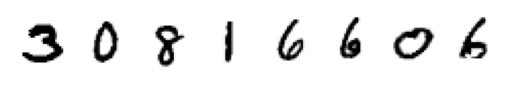

In [5]:
xb, yb = next(iter(train_loader))
print('Input shape:', xb.shape)
print('Labels:', yb)
plt.imshow(torchvision.utils.make_grid(xb)[0], cmap='Greys');
plt.axis('off');

Las dimensiones del input son `B=8x1x28x28`, ya como bien sabemos, MNIST son imagenes en blanco y negro (1 canal a diferencia de RGB), y su dimensiones espaciales son 28x28.

### 1.1 Proceso de corrupción por ruido

Sabemos que la distorsión del input con ruido es un componente fundamental en los modelos de difusión. Existen varios <a href="https://huggingface.co/docs/diffusers/using-diffusers/schedulers" target="_blank">schedulers</a>--al menos 13 implementados en la librería diffusers--para inyectar ruido a diferentes niveles de varianza, de manera determista o estocástica, según el largo de la cadena de difusión.

Concentrandonos solo en la función esencial de este componente, lo que estamos haciendo es tomar una imagen y mezclarla en algún % con un nivel de ruido.

In [6]:
def inject_noise(x, amount):
  """Given the input x, inject the given amount of noise to get intermediate states"""
  noise = torch.rand_like(x)
  amount = amount.view(-1,1,1,1)
  return x*(1-amount) + noise*amount

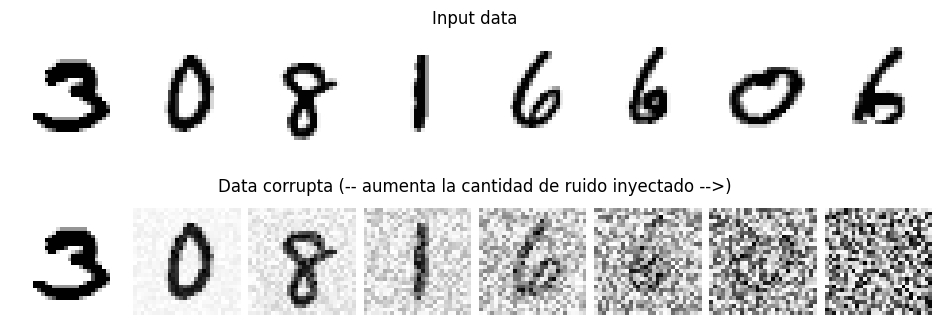

In [7]:
# Visualizar el batch de imagenes del input
fig, axbs = plt.subplots(2, 1, figsize=(12, 4))
axbs[0].set_title('Input data')
axbs[0].imshow(torchvision.utils.make_grid(xb)[0], cmap='Greys')
axbs[0].axis('off');

# Inyectar ruido al input
amount = torch.linspace(0, 1, xb.shape[0]) # Left to right -> more corruption
noised_xb = inject_noise(xb, amount)

# Visualizar los estados intermedios, o input corrompido con ruido
axbs[1].set_title('Data corrupta (-- aumenta la cantidad de ruido inyectado -->)')
axbs[1].imshow(torchvision.utils.make_grid(noised_xb)[0], cmap='Greys');
axbs[1].axis('off');

### 1.2 Modelo para predecir ruido

Desearíamos contar con un modelo capaz de procesar imágenes ruidosas de 28x28 píxeles y generar una predicción del mismo tamaño. Una elección común en este contexto es una arquitectura denominada UNet. <a href="https://arxiv.org/abs/1505.04597" target="_blank">Inicialmente concebida para tareas de segmentación en imágenes médicas</a>, una arquitectura UNet consta de un 'trayecto de compresión', donde los datos se reducen, y un 'trayecto de expansión', donde se restauran a la dimensión original (similar a un autoencoder). Además, incluye conexiones de salto que posibilitan el flujo de información y gradientes a través de distintos niveles.

Aunque algunos UNets incorporan bloques complejos en cada etapa, para esta demostración básica optaremos por construir un ejemplo mínimo. Este tomará una imagen de un solo canal y la dirigirá a través de tres capas convolucionales (`nn.Conv2d`) en el trayecto descendente (las capas descendentes en el diagrama y código) y tres en el trayecto ascendente, con conexiones de salto entre las capas descendentes y ascendentes. Emplearemos `nn.MaxPool2d` para el submuestreo y `nn.Upsample` para el sobre muestreo, en lugar de depender de capas aprendibles presentes en UNets más complejos. A continuación, se presenta una estructura aproximada que indica el número de canales en la salida de cada capa:

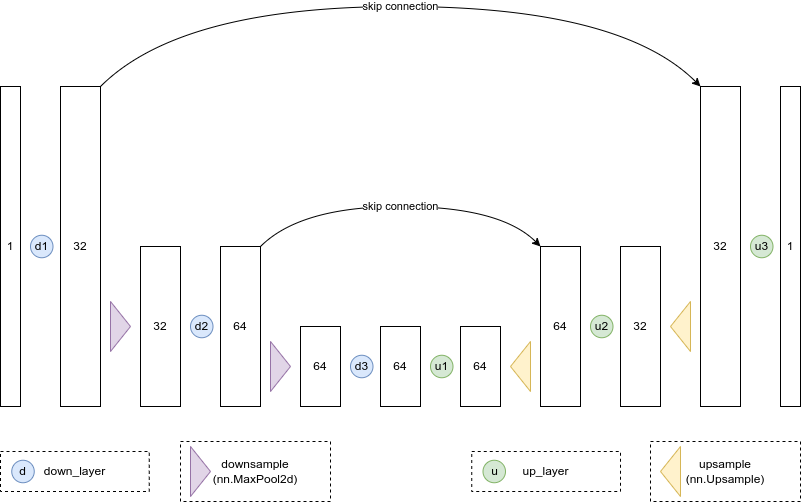

> b) (1.5 pts) Implemente la arquitectura `UNet` propuesta en el diagrama anterior.

In [8]:
class UNet(nn.Module):
  # Iniciar red con parámetros de entrada y crear redes del diagrama
  def __init__(self, in_channels=1, out_channels=1):
    super(UNet, self).__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.d1 = nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1)
    self.d2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.d3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
    self.downsample = nn.MaxPool2d(kernel_size=2)
    self.u1 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
    self.u2 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
    self.u3 = nn.Conv2d(32, out_channels, kernel_size=3, stride=1, padding=1)
    self.upsample = nn.Upsample(scale_factor=2)
    self.relu = nn.ReLU()


  #  Paso forward por cada red + relu con down y up sample
  def forward(self, x):
    x = self.relu(self.d1(x))
    skip_1 = x.detach().clone()
    x = self.downsample(x)
    x = self.relu(self.d2(x))
    skip_2 = x.detach().clone()
    x = self.downsample(x)
    x = self.relu(self.d3(x))
    x = self.relu(self.u1(x))
    x = self.upsample(x)
    x = x + skip_2
    x = self.relu(self.u2(x))
    x = self.upsample(x)
    x = x + skip_1
    x = self.relu(self.u3(x))
    return x

Primer _sanity check_ que la data fluya correctamente a traves de nuestro modelo y obtengamos las dimensiones esperadas.

In [9]:
model = UNet()
print(f'Input shape: {xb.shape}')
print(f'Output shape: {model(xb).shape}')
assert xb.shape == model(xb).shape, 'Problemas de implementación; la predicción debe ser del mismo tamaño que el input!'

Input shape: torch.Size([8, 1, 28, 28])
Output shape: torch.Size([8, 1, 28, 28])


Es bueno saber la complejidad de nuestro modelo, ¿cuantos parámetros tiene la red que implementó?

In [10]:
sum([p.numel() for p in model.parameters()])

111425

### 1.3 Entrenar la red

Disponemos de todos los elementos para entrenar nuestro modelo.

1. Dado un nivel de ruído (obtenido con `torch.rand`) para cada imagen del batch, podemos corromper el input con `inject_noise` para obtener el estado intermedio.
1. Somos capaces de predecir la imagen a partir de una imagen corrupta con nuestra `UNet` recién implementada.
1. La función `nn.MSELoss` nos permite medir el nivel de deajuste entre la predicción y la imagen original, para así ajustar los parámetros y disminuir la función de pérdida usando un optimizador como `torch.optim.Adam`.


**Nota:** Con `B=128` y entrenamiento por `n_epochs=3`, me tomó 33 segundos el entrenamiento con una instancia con T4 en Google Colab. Las `n_epochs=25` de entrenamiento tardaron 4m31s.

> c) (2.0 pts) Entrene su modelo de difusión durante 3 o 5 épocas y grafiqué la función de pérdida.

In [11]:
def train(model, iterator, optimizer, criterion, device):
  epoch_loss = 0

  #We have to set the neural network in training mode. This is because during
  #training, we need gradients and complementary data to ease the computation
  model.train()

  #Training loop
  for (x, y) in iterator:
    x = x.to(device) # Data

    optimizer.zero_grad() # Clean gradients

    noised_x = inject_noise(x, amount) # Input con ruido
    noised_x.to(device)

    pred = model(noised_x) # Predicción

    loss = criterion(pred, x) # Compute the loss

    loss.backward() # Compute gradients

    optimizer.step() # Apply update rules

    epoch_loss += loss.item()

  return epoch_loss / len(iterator)

In [12]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [13]:
B = 128
train_loader = DataLoader(dataset, batch_size=B, shuffle=True, drop_last=True)

# How many runs through the data should we do?
n_epochs = 5

# Create the network
model = UNet()
model.to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Noise scale
amount = torch.linspace(0, 1, B) # Left to right -> more corruption
amount = amount.to(device)

In [14]:
#Let's perform the training

best_valid_loss = float('inf')

for epoch in range(n_epochs):

  start_time = time.time()

  #Train cycle
  train_loss = train(model, train_loader, optimizer, loss_fn, device)

  end_time = time.time()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f}')

Epoch: 01 | Epoch Time: 0m 26s
	Train Loss: 0.024
Epoch: 02 | Epoch Time: 0m 9s
	Train Loss: 0.018
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.016
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.015
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.015


Ok, ahora tenemos nuestro modelo entrenado, podemos visualizar un par de predicciones del modelo para ciertos niveles de ruído.

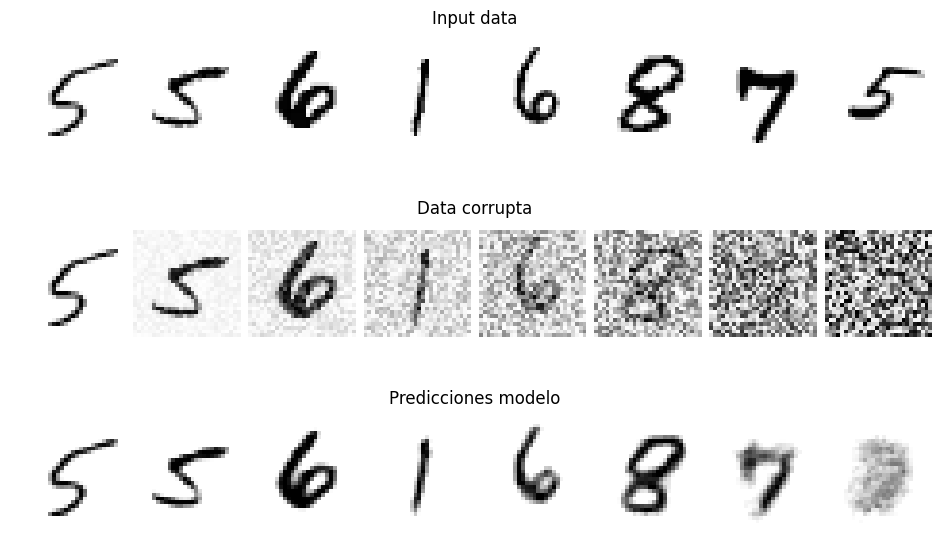

In [15]:
# Fetch some data
xb, yb = next(iter(train_loader))
xb = xb[:8] # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
amount = torch.linspace(0, 1, xb.shape[0]) # Left to right -> more corruption
noised_x = inject_noise(xb, amount)

# Get the model predictions
with torch.no_grad():
  preds = model(noised_x.to(device)).detach().cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(xb)[0].clip(0, 1), cmap='Greys')
axs[0].axis('off');
axs[1].set_title('Data corrupta')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap='Greys')
axs[1].axis('off');
axs[2].set_title('Predicciones modelo')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap='Greys');
axs[2].axis('off');

Las predicciones del modelo son bastante certeras, excepto cuando los niveles de ruído son altos ¿Por qué?

Además, si queremos obtener muestras a partir del modelo, necesitamos partir desde solo ruído.

**Respuesta:** Como se puede ver en la celda anterior, el modelo captura bien lo que es la data del input pues predice los mismos dígitos incluso cuando hay ruido en ellos, sin embargo, cuando la data de input es prácticamente solo ruido, el modelo no logra predecir correctamente y sobrepone predicciones posibles. Es por esto último que se ve una mancha gris en la última predicción.  

La explicación de cómo generamos datos dado el problema anterior (pues la idea es partir de puro ruido) viene ya explicada en el enunciado.

### 1.4 Proceso de muestreo

Si nuestras predicciones no son muy precisas en condiciones de alto ruido, ¿cómo generamos imágenes?

Bueno, **¿y si partimos de un conjunto de datos aleatorio, examinamos las predicciones del modelo pero solo nos desplazamos en una pequeña medida hacia esa predicción, digamos, un 10% del camino?** En este momento, contamos con una imagen extremadamente ruidosa en la que posiblemente se vislumbre una sugerencia de estructura, que podemos ingresar al modelo para obtener una nueva predicción. La expectativa es que esta nueva predicción sea ligeramente mejor que la inicial (dado que nuestro punto de partida es un poco menos ruidoso), permitiéndonos así dar otro pequeño paso con esta predicción mejorada. A lo largo de unos pocos pasos, las estructuras empiezan a emerger y perfeccionarse, culminando en nuestras salidas finales.

Repetimos este proceso varias veces y, si todo va según lo planeado, obtenemos una imagen.

> d) (1.0 pts) Implemente el proceso de muestreo descrito arriba.

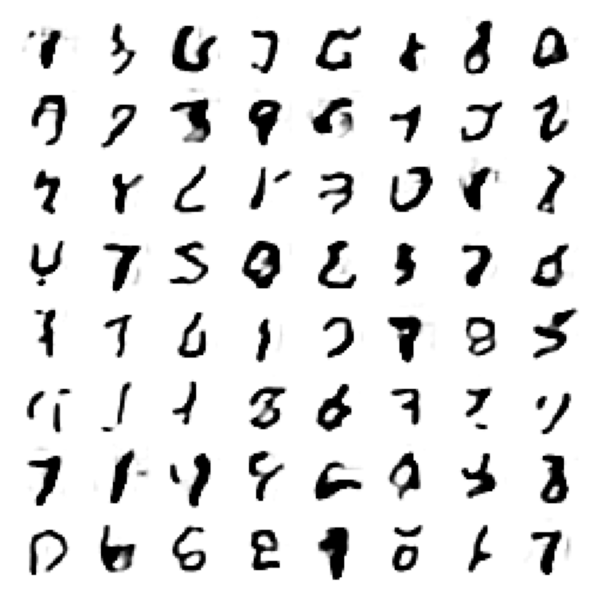

In [16]:
n_steps = 80
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
  with torch.no_grad():
    pred = model(x)
  mix_factor = 1/(n_steps - i)
  x = x * (1-mix_factor) + pred * mix_factor

fig, ax = plt.subplots(1, 1, figsize=(7.5, 7.5))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')
ax.axis('off');

## 2. Modelos de difusión pre-entrenados: Muestreo rápido con DDIM y condicionar con _classifier guidance_

Descargamos un modelo de difusión previamente entrenado utilizando un dataset reconocido en el ámbito de los modelos generativos ([Karras et al., 2018](https://arxiv.org/abs/1710.10196v3)), específicamente el conjunto de datos [CelebA-HQ](https://paperswithcode.com/dataset/celeba-hq). Este conjunto de datos se empleó con una resolución de 256x256 con el propósito de realizar experimentos y demostrar el potencial de los modelos de difusión, tal como se expuso en el influyente artículo sobre DDPM ([Ho et al., 2020](https://arxiv.org/abs/2006.11239)).

In [17]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
image_pipe.to(device);

model_index.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors not found


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

Puedes generar muestras de este modelo utilizando la librería `diffusers` 🧨 de esta manera.

  0%|          | 0/1000 [00:00<?, ?it/s]

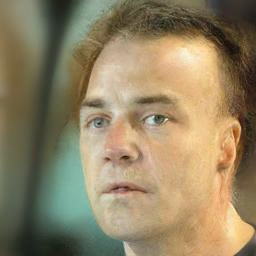

In [18]:
images = image_pipe().images
images[0]

Para obtener una muestra, es necesario atravesar los $1000$ pasos de la cadena de difusión, eliminando gradualmente el ruido desde un estado inicial de ruido gaussiano absoluto hasta alcanzar la muestra final.

Acelerar el proceso de muestreo es una línea de investigación activa, ¿cómo podemos reducir el tiempo de generación de muestras sin sacrificar la calidad de esta? Las técnicas que van en esta línea deben lidear con el díficil _trade-off_ de reducir la latencia del proceso de muestreo y degradar la calidad de las muestras generadas.

### 2.1 Muestreo rápido con DDIM

> a) (1.5 pts) Explique cómo el trabajo [_Denoising Diffusion Implicit Models (Song et al., 2021)_](https://arxiv.org/pdf/2010.02502.pdf) acelera el proceso de muestreo propuesto en el _framework_ DDPM. Debe ser específico en qué y cómo se diferencia respecto al trabajo DDPM.
>
> **Hint:** Recomendamos complementar su lectura con el [código fuente del método `.step()`](https://github.com/huggingface/diffusers/blob/v0.23.0/src/diffusers/schedulers/scheduling_ddim.py#L346) del `DDIMscheduler` de la librería `diffusers` que implementa la técnica (o `??scheduler.step` en un bloque de código para ver documentación en Colab).

**Respuesta:** En el proceso forward, en vez de considerar las $T$ variables latentes $x_{1:T}$, se considera un submuestreo de ellas, de tamaño $S$, es decir, $\{x_1,...,x_{\tau_S}\}$ donde $\tau$ es una subsecuencia creciente de $[1,...,T]$ de largo $S$. Así, se define ahora el proceso forward en $\{x_1,...,x_{\tau_S}\}$ tal que $q(x_{\tau_i} | x_0) = \mathcal{N}(\sqrt{\alpha_{\tau_i}} x_0, (1-\alpha_{\tau_i})I)$ iguale los "marginales". Notar que $\alpha$, siguiendo la notación del paper del enunciado, es una secuencia decreciente $\alpha_{1:T} \in (0,1]^T$
Con lo anterior, el proceso de generar datos samplea variables latentes de acuerdo al proceso reverso de $\tau$, por lo que cuando este es mucho menor que $T$, se consigue una eficiencia computacional mucho mayor.  

Por otro lado, la formulación original de DDPM sampleaba de la misma manera pero usando toda la secuencia de variables latentes $\{x_1,...,x_{T}\}$.

In [19]:
from diffusers import DDIMScheduler

# Create new scheduler and set num inference steps
scheduler = DDIMScheduler.from_pretrained("google/ddpm-celebahq-256")
scheduler.set_timesteps(num_inference_steps=40)

Los cadena de $1000$ pasos será computada solo en 40 pasos, es decir dando
brincos de $1000/40=25$ pasos respecto a los originales.

In [20]:
scheduler.timesteps

tensor([975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 725, 700, 675, 650,
        625, 600, 575, 550, 525, 500, 475, 450, 425, 400, 375, 350, 325, 300,
        275, 250, 225, 200, 175, 150, 125, 100,  75,  50,  25,   0])

Utilizando nuestro `image_pipe` y `scheduler` podemos controlar el proceso de muestreo para nuestro modelo de difusión de la siguiente forma:

0it [00:00, ?it/s]

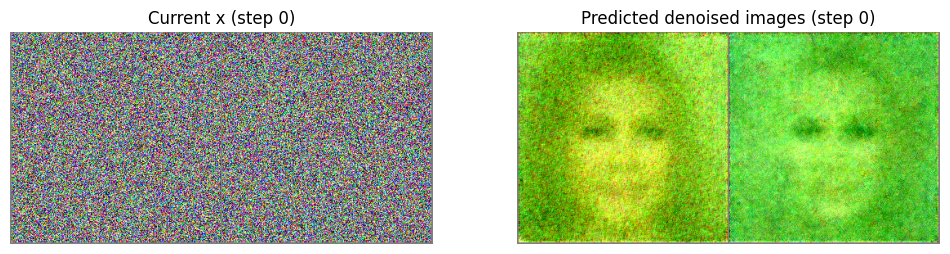

10it [00:02,  4.16it/s]

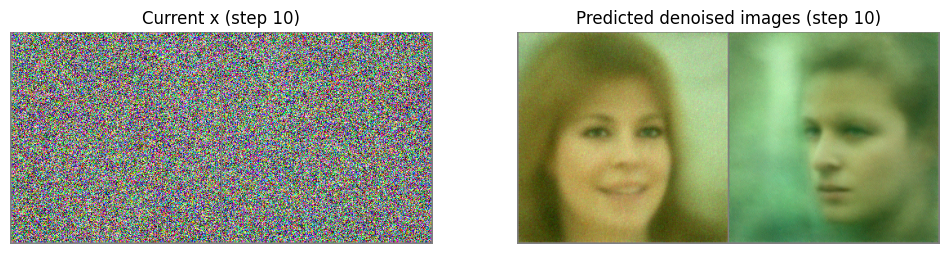

20it [00:05,  4.11it/s]

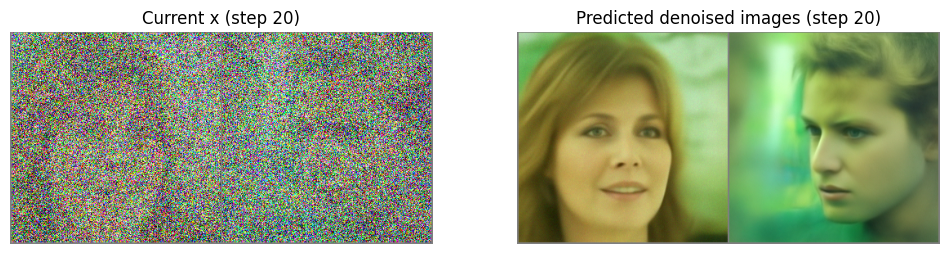

30it [00:07,  4.11it/s]

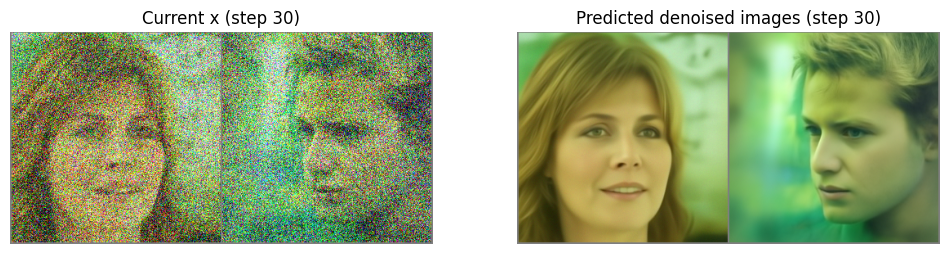

39it [00:10,  4.15it/s]

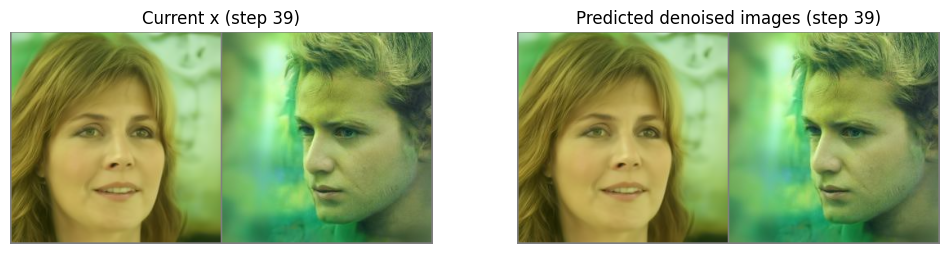

40it [00:11,  3.61it/s]


In [21]:
 # Iniciar con ruido gaussiano
x = torch.randn(2, 3, 256, 256).to(device)  # Batch de 2 imágenes, 3-canales, 256 x 256 px

# Iterar por el proceso de muestreo definido en los timestemps de denoising
for i, t in tqdm(enumerate(scheduler.timesteps)):

    # 1. Escalar input para el modelo
    model_input = scheduler.scale_model_input(x, t)

    # 2. Obtener predición del ruido dado el input escalado y el timestep t
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    # 3. Calcular la muestra actualizada según el scheduler
    scheduler_output = scheduler.step(noise_pred, t, x)

    # 4. Actualizar x
    # Nota: .step() devuelve una salida con un atributo prev_sample, siendo "previo"
    # porque estamos avanzando "hacia atrás" en el tiempo (backward process), desde
    # un nivel de ruido alto a uno bajo (lo opuesto al forward process).
    x = scheduler_output.prev_sample

    # (Utilidad) Visualizar cada tanto x y las imagenes predichas con ruido removido
    if i % 10 == 0 or i == len(scheduler.timesteps) - 1:
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        grid = torchvision.utils.make_grid(x, nrow=2).permute(1, 2, 0)
        axs[0].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[0].set_title(f"Current x (step {i})")
        axs[0].axis('off');

        pred_x0 = (
            scheduler_output.pred_original_sample
        )
        grid = torchvision.utils.make_grid(pred_x0, nrow=2).permute(1, 2, 0)
        axs[1].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[1].set_title(f"Predicted denoised images (step {i})")
        axs[1].axis('off');
        plt.show()

Los pasos del código para muestrear son clave para la siguiente sección, donde intervendremos en el proceso de generación durante el muestreo. ¡Es crucial comprender el código anterior antes de continuar!

### 2.2 Classifier Guidance Parte I: Modificando el proceso de muestreo

Aquí veremos cómo controlar un modelo generativo con capacidades ya instaladas. Una opción es entrenar un modelo condicionado desde el principio. Por ejemplo, modelos como <a href="https://arxiv.org/abs/2204.06125" target="_blank">DALL-E2</a> de OpenAI, o <a href="https://arxiv.org/abs/2205.11487" target="_blank">IMAGEN</a> de Google fueron entrenados desde el inicio para aceptar entrada de texto a imagen, lo que permite generar muestras a través de descripciones de texto o _prompts_ como en el siguiente video.

In [22]:
from IPython.display import YouTubeVideo
YouTubeVideo('8fthDHDshvg?si=BGqpwlUYTR-jAlJ2', width=650, height=425)

Emplear un modelo preentrenado y guiar su proceso de muestreo con un clasificador externo es otro enfoque. Utilizamos una función de condicionamiento para medir la proximidad del candidato a muestra con nuestro objetivo. Minimizamos esta función durante el proceso de _denoising_, guiando cada paso en la dirección opuesta del gradiente para reducir nuestra función objetivo.
Este método fue propuesto en el contexto de modelos de difusión en  <i><a href="https://arxiv.org/abs/2105.05233" target="_blank">Diffusion Models Beat GANs on Image Synthesis (Dhariwal, Nichol 2021)</a></i> y perfeccionado en <i><a href="https://arxiv.org/abs/2105.05233" target="_blank">GLIDE: Towards Photorealistic Image Generation and Editing with Text-Guided Diffusion Models (Nichol et al, 2022)</a></i>. La idea fundamental es que el modelo preentrenado de difusión no se actualiza, sino que aprendemos un clasificador externo que guía el proceso de _denoising_.

> b) (0.5 pts) Dado $t=1,\dots,T$, de una expresión para el score del modelo condicional $p(x_t|c)$ para una clase o condición $c$ que no depende directamente de $x_t$. Justifique con esto la expresión de condicionamiento con _Classifier Guidance_.

**Respuesta:** Por Bayes,

\begin{equation}
  p(x_t | c) \propto \frac{p(x_t | c)}{p(x_t)}
\end{equation}
Así, al calcular su score obtenemos
\begin{equation}
  \nabla_{x_t}p(x_t | c) \propto \nabla_{x_t} \bigg(\frac{p(x_t | c)}{p(x_t)}\bigg)
  = \nabla_{x_t}p(x_t | c) - \nabla_{x_t}p(x_t)
  \propto \epsilon^*(x_t|c) - \epsilon^*(x_t)
\end{equation}

donde $\epsilon^*$ representa los scores reales.

In [23]:
def color_loss(images, target_color=(1.0, 0.34, 0.2)):
    """Dado un color objetivo (R, G, B), devuelve una pérdida que indica qué tan
       lejos, en promedio, están los píxeles de las imágenes de ese color. Por
       defecto, se establece el color "carmín": (1.0, 0.34, 0.2)
    """
    target = (
        torch.tensor(target_color).to(images.device) * 2 - 1
    ) # Mapear el color objetivo a (-1, 1)
    target = target[
        None, :, None, None
    ]  # Agregar dimensiones para "broadcastear" con tensor de imagenes (B, C, H, W)
    error = torch.abs(
        images - target
    ).mean()  # Promedio de la diferencia absoluta entre los pixeles de la imagen y el color objetivo
    return error

Nuestra función de costo medira que tan distante se encuentra la muestra de imagen durante el "proceso de generación" con respecto a una lámina de color. El color por defecto será <i><a href="https://htmlcolorcodes.com/colors/carmine/" target="_blank">Carmín</a></i>, que si no lo conoces, es el siguiente:

<center><img src="https://htmlcolorcodes.com/assets/images/colors/carmine-color-solid-background-1920x1080.png" class="color-swatch__image" alt="Carmine color" height="200px" width="200px"></center>




Utilicemos de prueba para la función de costo una de las últimas imágenes que generamos en la sección anterior.

In [24]:
example_image = pred_x0.cpu()[0,:,:,:]

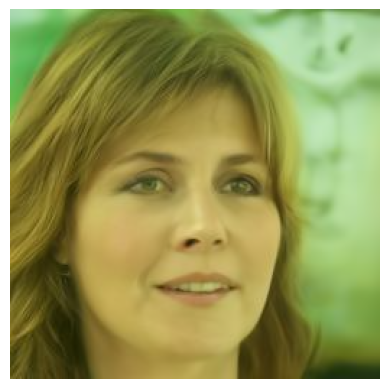

In [25]:
plt.imshow(example_image.permute(1,2,0).clip(-1, 1) * 0.5 + 0.5);
plt.axis('off');

In [26]:
color_loss(example_image)

tensor(0.5613)

Esto proporciona un escalar, lo crucial es que podemos calcular gradientes con respecto a este valor y usarlos para reducir la discrepancia entre la imagen generada y la paleta de colores objetivo. Aunque la función de costo es para la optimización, su construcción es vital para "guiar" el proceso de muestreo hacia nuestro objetivo "visual".

> c) (2.0 pts) A continuación, debe crear una versión modificada del proceso de muestreo para generar imágenes con caras con aire de famoso con color carmín predominante, donde, en cada paso, ejecutará las siguientes acciones:
>
>1. Generar una nueva versión de x con `requires_grad_ = True` (dado en código ayuda).
2. Calcular la versión sin ruido ($\boldsymbol{x}_0$).
3. Introducir el $\boldsymbol{x}_0$ predicho en nuestra `color_loss` definida anteriormente.
4. Encontrar el gradiente de esta función de pérdida con respecto a $\boldsymbol{x}$. **Hint:** Investigué como utilizar `torch.autograd.grad` para este paso.
5. Utilizar este gradiente de condicionamiento para ajustar $\boldsymbol{x}$ antes de avanzar con el `scheduler`, con la esperanza de dirigir $\boldsymbol{x}$ en una dirección que conduzca a una pérdida menor según nuestra función guía.


1it [00:00,  1.06it/s]

0 loss: 22.98773956298828


11it [00:10,  1.05it/s]

10 loss: 10.822978019714355


21it [00:20,  1.03it/s]

20 loss: 10.539712905883789


31it [00:29,  1.02it/s]

30 loss: 10.615283012390137


40it [00:38,  1.03it/s]


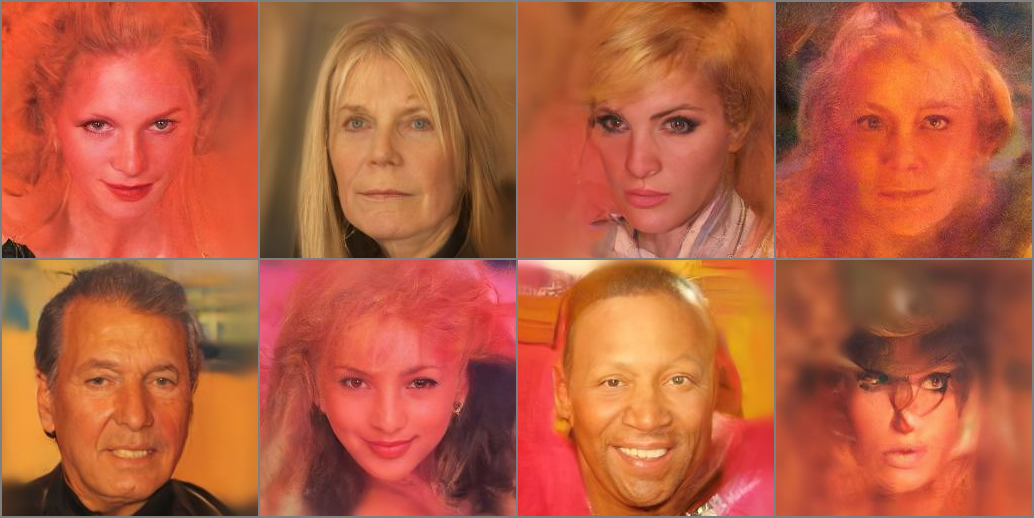

In [27]:
# El factor guidance determina que tan fuerte es el efecto a inducir (color en este caso)
guidance_loss_scale = 36  # Explore distintos rangos como 5, 10, o 100

x = torch.randn(8, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps)):
  # ----------------------------------------------------------------------------

  # Paso 1. Escalar input para el modelo
  model_input = scheduler.scale_model_input(x, t)

  # Paso 2. Obtener predición del ruido dado el input escalado y el timestep t
  with torch.no_grad():
      noise_pred = image_pipe.unet(model_input, t)["sample"]

  # Paso 3: activar grafo de gradientes para autograd/backprop
  x = x.detach().requires_grad_()

  x0 = scheduler.step(noise_pred, t, x).pred_original_sample

  # Paso 4. Calcular loss
  loss = color_loss(x0) * guidance_loss_scale

  # Printear loss
  if i % 10 == 0:
      print(i, "loss:", loss.item())

  # Paso 5. Obtener gradiente
  gradiente = -torch.autograd.grad(loss, x)[0]

  # Paso 6. Modificar x
  x = x.detach() + gradiente

  # Paso 7. Scheduler step
  x = scheduler.step(noise_pred, t, x).prev_sample

  # ----------------------------------------------------------------------------


# Visualice las muestras generadas
grid = torchvision.utils.make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5

Image.fromarray(np.array(im * 255).astype(np.uint8))

**Nota.**

Hay dos variantes que podemos explorar para el proceos de generación de muestras anterior.

1. En la primera, habilitamos requires_grad en $\boldsymbol{x}$ después de obtener nuestra predicción de ruido del modelo `UNet`. Este enfoque es más eficiente en términos de memoria (ya que evita rastrear gradientes a través del modelo de difusión) pero proporciona un gradiente menos precisos.
2. En la segunda variante, habilitamos requires_grad en $\boldsymbol{x}$ primero y luego lo introducimos en `UNet` para calcular el $\boldsymbol{x_0}$ predicho.

En las instrucciones anteriores, se indicadaba la primera que es más eficiente en memoria, siente libertad de explorar con la segunda variante.

### 2.3 Classifier Guidance Parte II: Condicionamiento vía prompts, modelo CLIP

Contar con la capacidad de dirigirnos hacia un color nos otorga cierto nivel de control, pero es posible agregar alguna descripcción, o _prompt_, para guiar el proceso de generación con el enfoque _classifier guidance_?

<a href="https://openai.com/research/clip" target="_blank">CLIP es un modelo desarrollado por OpenAI</a> que posibilita la comparación entre imágenes y descripciones de texto. Esto nos permite medir de manera cuantitativa la concordancia entre una imagen y un _prompt_. Además, como el proceso es diferenciable, podemos emplearlo como una función de pérdida para guiar nuestro modelo de difusión.

Si quieres saber más sobre DALLE-2, recomendamos ver el video de la <a href="https://www.youtube.com/watch?v=TvBjoN3zkPY&list=PLfeYlJzwvDN3HmOGKtB78VjkB0W7E7Sy8&index=11&t=1s" target="_blank">presentación de ML Collective de Aditya Ramesh sobre el modelo</a>, uno de los autores del modelo. **Importante**, no es necesario para terminar el lab.

In [28]:
from IPython.display import YouTubeVideo
YouTubeVideo('TvBjoN3zkPY?si=rIVEs6T8_r7ZwSQ8', width=650, height=425)

Comencemos cargando el modelo CLIP de OpenAI.

In [29]:
import open_clip

clip_model, _, preprocess = open_clip.create_model_and_transforms(
    "ViT-B-32", pretrained="openai"
)

# enviar al mismo device
clip_model.to(device)

# instanciar transformaciones para que las imágenes sigan las mismas transformaciones
# que la data de entrenamiento del modelo CLIP
tfms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.RandomAffine(
            5
        ),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.Normalize(
            mean=(0.48145466, 0.4578275, 0.40821073),
            std=(0.26862954, 0.26130258, 0.27577711),
        ),
    ]
)

100%|███████████████████████████████████████| 354M/354M [00:07<00:00, 49.1MiB/s]


Establecemos la función de costo para comparar los _embeddings_ de una imagen con los del _prompt_.

In [30]:
# And define a loss function that takes an image, embeds it and compares with
# the text features of the prompt
def clip_loss(image, text_features):
    """Dado una imagen y un vector de características objetivo extraído de los
       embeddings del prompt, devuelve una pérdida que indica una métrica de
       distancia entre ambos embeddings. ¿Por qué esta métrica? Empirismo puro...
    """
    image_features = clip_model.encode_image(
        tfms(image)
    )
    input_normed = torch.nn.functional.normalize(image_features.unsqueeze(1), dim=2)
    embed_normed = torch.nn.functional.normalize(text_features.unsqueeze(0), dim=2)
    dists = (
        input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
    )  # Squared Great Circle Distance
    return dists.mean()

Utilizaremos nuestro modelo generativo preentrenado para generar rostros de personas famosas. A través de un _prompt_, manipularemos la información comprimida del conjunto de datos CelebA-HQ. Sin intenciones de discriminar por edad, buscaremos generar imágenes de rostros con un aspecto de personas famosas mayores.

In [31]:
# Nota: CLIP no funciona bien con captions en otros idiomas que no sean ingles, al
# menos esta versión
prompt = "old, senior, oldster, elderly, golden-ager, grandpa"

El modelo CLIP genera un representación vectorial conjunta de imágenes y descripcciones, podemos llegar a este _joint embedding space_ tanto por texto o imagen. Probemos como ir a este espacio latente compartido a partir del texto de nuestro _prompt_.

Primero debemos tokenizar el texto a un tensor de índices según la tokenización del modelo, este procedimiento es identifico al utilizado en la unidad de modelos autoregresivos del curso.

In [32]:
prompt_tokens = open_clip.tokenize([prompt])
prompt_tokens.shape, prompt_tokens

(torch.Size([1, 77]),
 tensor([[49406,   896,   267,  3415,   267,  4931,   881,   267, 15455,   267,
           3878,   268, 10443,   267, 14582, 49407,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0]]))

Luego, obtenemos los _embeddings_ de 512 dimensiones que representan a la secuencia de tokens con `clip_model.encode_text()`. Nos aseguramos de no asociar el tensor a un grafo de gradientes, dado que este vector solo será de referencia y no necesitamos parámetros para modificarlo.

In [33]:
with torch.no_grad():
  text_features = clip_model.encode_text(prompt_tokens.to(device))
text_features.shape

torch.Size([1, 512])

In [34]:
assert text_features.grad == None, "No instanciar grafo de gradientes"

In [35]:
torch.finfo(text_features.dtype)

finfo(resolution=1e-06, min=-3.40282e+38, max=3.40282e+38, eps=1.19209e-07, smallest_normal=1.17549e-38, tiny=1.17549e-38, dtype=float32)

Es posible también disminuir la precisión de este tensor para disminuir requerimientos de memoría, pero no deberíamos tener mayores problemas con Colab y pequeños batches de imágenes a generar de 256x256.

In [36]:
# with torch.no_grad(), torch.cuda.amp.autocast():
#   text_features = clip_model.encode_text(prompt_tokens.to(device))
# text_features.shape

# revisar precision con float32 -a-> 16fp
#torch.finfo(text_features.dtype)

Usando la imagen anterior de ejemplo, exploremos cómo obtener los _embeddings_ usando `clip_model.encode_image()`.

In [37]:
with torch.no_grad():
  # obtenemos embeddings a partir de la imagen (tensor sin grafo de gradientes)
  image_features = clip_model.encode_image(
      # aplicamos transformaciones del modelo CLIP a la imagen
      tfms(
          # agregar batch dimension al tensor y dejamos en el mismo device
          example_image.unsqueeze(0).to(device)
          )
    )

# vemos el número de features
image_features.shape

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([1, 512])

Ahora sabemos como se obtienen los _embeddings_ usando el modelo CLIP. Las transformaciones al tensor que representa la imagen son aplicadas en `clip_loss`.

> d) (2.0 pts) A continuación, debe crear una versión modificada del proceso de muestreo para generar imágenes con caras con aire de famoso guiadas por un _prompt_, donde, en cada paso, ejecutará las siguientes acciones:
1. Para cada paso en el proceso del modelo de difusión:
>  * Crear varias variantes de la imagen denoise predicha para obtener una estimación más robusta de la función de costo. Respecto a la sección anterior, que solo computamos los gradientes según la estimación de la función de costo a partir de 1 muestra. Acá utilizará `n_cuts` para controlar el número de imágenes a utilizar en cada paso del proceso de difusión para estimar la función de costo.
   * Para cada variante debe obtener los _embeddings_ de la imagen con CLIP y compararlos con los _embeddings_ del _prompt_ (`text_features`) utilizando la `clip_loss` (recuerde el `guidance_scale`). Se recomienda acumular los gradientes escalador por el número de variantes.
2. Escalar el gradiente estimado por el nivel de ruido $\sqrt{1-\bar{\alpha}_t}$ asociado al _timestep_ $t$ del _scheduler_, y utilizarlo para modificar $\boldsymbol{x}$.
>
> Comenté cuál puede ser el razonamiento detrás escalar los gradientes según se indica en el paso 2. **Hint:** piense sobre la generación de caras.
>
> **Nota:** Debe obtener previamente los `text_features` de su _prompt_, un tensor de _embeddings_ CLIP de 512 dimensiones.

1it [00:01,  1.59s/it]

Step: 0 , Guidance loss: 7.8784308433532715


26it [00:42,  1.62s/it]

Step: 25 , Guidance loss: 7.431692123413086


51it [01:22,  1.61s/it]

Step: 50 , Guidance loss: 7.556028366088867


76it [02:02,  1.65s/it]

Step: 75 , Guidance loss: 7.657477855682373


101it [02:42,  1.65s/it]

Step: 100 , Guidance loss: 7.548543453216553


120it [03:12,  1.61s/it]


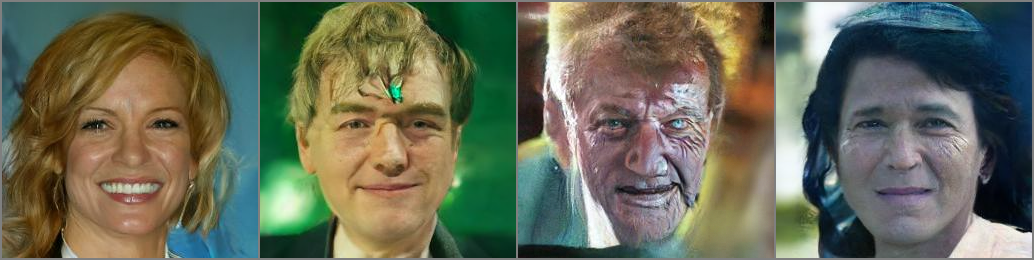

In [38]:
guidance_scale = 8.47865

# número de variantes durante cada denoising step de imagenes candidatas
# para computar gradientes
n_cuts = 32

# Aumentar el número de pasos aumenta la exposición del clasificador guía
scheduler.set_timesteps(120)

# Generar 4 imagenes RGB de 256x256 (resolución del modelo DDPM CelebA-HQ)
x = torch.randn(4, 3, 256, 256).to(
    device
)

for i, t in tqdm(enumerate(scheduler.timesteps)):
  # ----------------------------------------------------------------------------

  model_input = scheduler.scale_model_input(x, t)

  # Predecir ruido
  with torch.no_grad():
      noise_pred = image_pipe.unet(model_input, t)["sample"]

  gradiente = 0

  for cut in range(n_cuts):

      x = x.detach().requires_grad_()

      # Predecir x0
      x0 = scheduler.step(noise_pred, t, x).pred_original_sample

      # Calcular loss
      loss = clip_loss(x0, text_features) * guidance_scale

      # Obtener gradiente
      gradiente = gradiente - (1/n_cuts * torch.autograd.grad(loss, x)[0])

  if i % 25 == 0:
      print("Step:", i, ", Guidance loss:", loss.item())

  # Modificar x
  alpha_bar = scheduler.alphas_cumprod[i]
  x = (
      x.detach() + gradiente * alpha_bar.sqrt()
  )

  # Scheduler step
  x = scheduler.step(noise_pred, t, x).prev_sample

  # ----------------------------------------------------------------------------

# Printear imágenes
grid = torchvision.utils.make_grid(x.detach(), nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))

Un poco creepy las caras pero bueno, se logró algo jajaja

~~~ Fin del Lab ~~~